# Projet numérique de Science des Données 2025

__Binôme numéro 54 -- OLEKHNOVITCH Simon et CALLENS Sophie__

## Introduction

Dans ce projet, il s'agira d'étudier un jeu de données concernant des femmes diabétiques enceintes. Le diabète constitue un facteur de risque pour le bon déroulé de la grossesse. Pour chacune de ces femmes, nous disposons de 7 variables :
* `Age` : l'âge en années
* `Tension systolique` : la tension systolique en mmHg
* `Tension diastolique` : la tension diastolique en mmHg
* `Glycémie` : glycémie post-prandiale en mmol/L
* `Température` : température en °C
* `FC au repos` : fréquence cardiaque au repos
* `Risque` : degré de risque obstétrique (0 : faible, 1 : moyen, 2 : élevé)


Ce projet comporte trois partie :
1. Une analyse exploratoire des données
2. La construction d'un classifieur binaire permettant de séparer les femmes dont la grossesse est à risque de celles dont elle ne l'est pas
3. La construction d'un classifieur multi-classe permettant de séparer les grossesses en trois classes : hautement à risque, moyennement à risque, faiblement à risque.

## Instructions 
* Former un binôme et l'inscrire dans Moodle.
* Renseigner le numéro de binôme et vos noms tout en haut de ce notebook à l'emplacement indiqué.
* Déposer ce notebook complété **au plus tard le 10 juillet 2025, 23h59** sur Moodle.

La présence aux séances dédiés au mini-projet (20/06 et 7/07) est **notée**. 

Les questions **1 à 14** peuvent être traitées dès la première séance. 
La question **15** peut être traitée après la PC4.
Les questions **16 à 30** peuvent être traitées à partir de la PC5.

Pour des raisons pédagogiques (voir la note à ce sujet), **l'usage d'assistants de code ou d'agents conversationnels tels que ChatGPT, Copilot, Claude, LeChat est prohibé. Leur utilisation sera sanctionnée.**

### Question 1 (1pt)

Les données ont été récoltées dans une région défavorisée du monde, où les populations sont très pauvres et peuvent difficilement consulter. Quel peut être l'intérêt de déléguer à un algorithme la prédiction du risque obstétrique ? Quelles peuvent être les dérives (sociales, éthiques, économiques, psychologiques) d'une telle pratique ?

Il est très interessant, dans une région défavorisée qui a peu accés aux soins, de s'interesser à une détection du risque de maladie par algorithme. En effet cette solution est *bien moins couteuse* et *beacoup plus efficace* quand elle s'adresse à un grand nombre d'individu. Il s'agit, avec cette méthode, de faire un premier tri à moindre cout (pour le patient comme pour l'organisme qui s'occupe de sa prise en charge) entre les personnes ne présentant aucun risques et celles qui en présente un, pour ensuite laisser place à un professionnel de la santé. Cela  permetterait aussi de désengorger ces services de santé qui sont trop solicités.

## Librairies usuelles

In [169]:
import pandas as pd

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

plt.rc('font', **{'size': 12}) # règle la taille de police globalement pour les plots (en pt)

np.random.seed(19) 

## Chargement des données

Nous allons pour l'instant travailler avec le jeu de données d'entraînement `data/donnees_entrainement.csv` :

In [238]:
df_train = pd.read_csv('data/donnees_entrainement.csv')
df_train.head(100)
df_train.shape

(800, 7)

Commençons par en extraire deux arrays, `X_train` et `y_train`, contenant d'une part les variables décrivant les observations et d'autre part leurs étiquettes :

In [171]:
X_train = np.array(df_train.drop('Risque', axis=1))
y_train = np.array(df_train['Risque'], dtype='int')

# 1. Exploration de données

## Distributions des variables

### Question 2 (1 pt)
Pour chaque variable, affichez un histogramme de sa distribution dans chacune des trois classes.

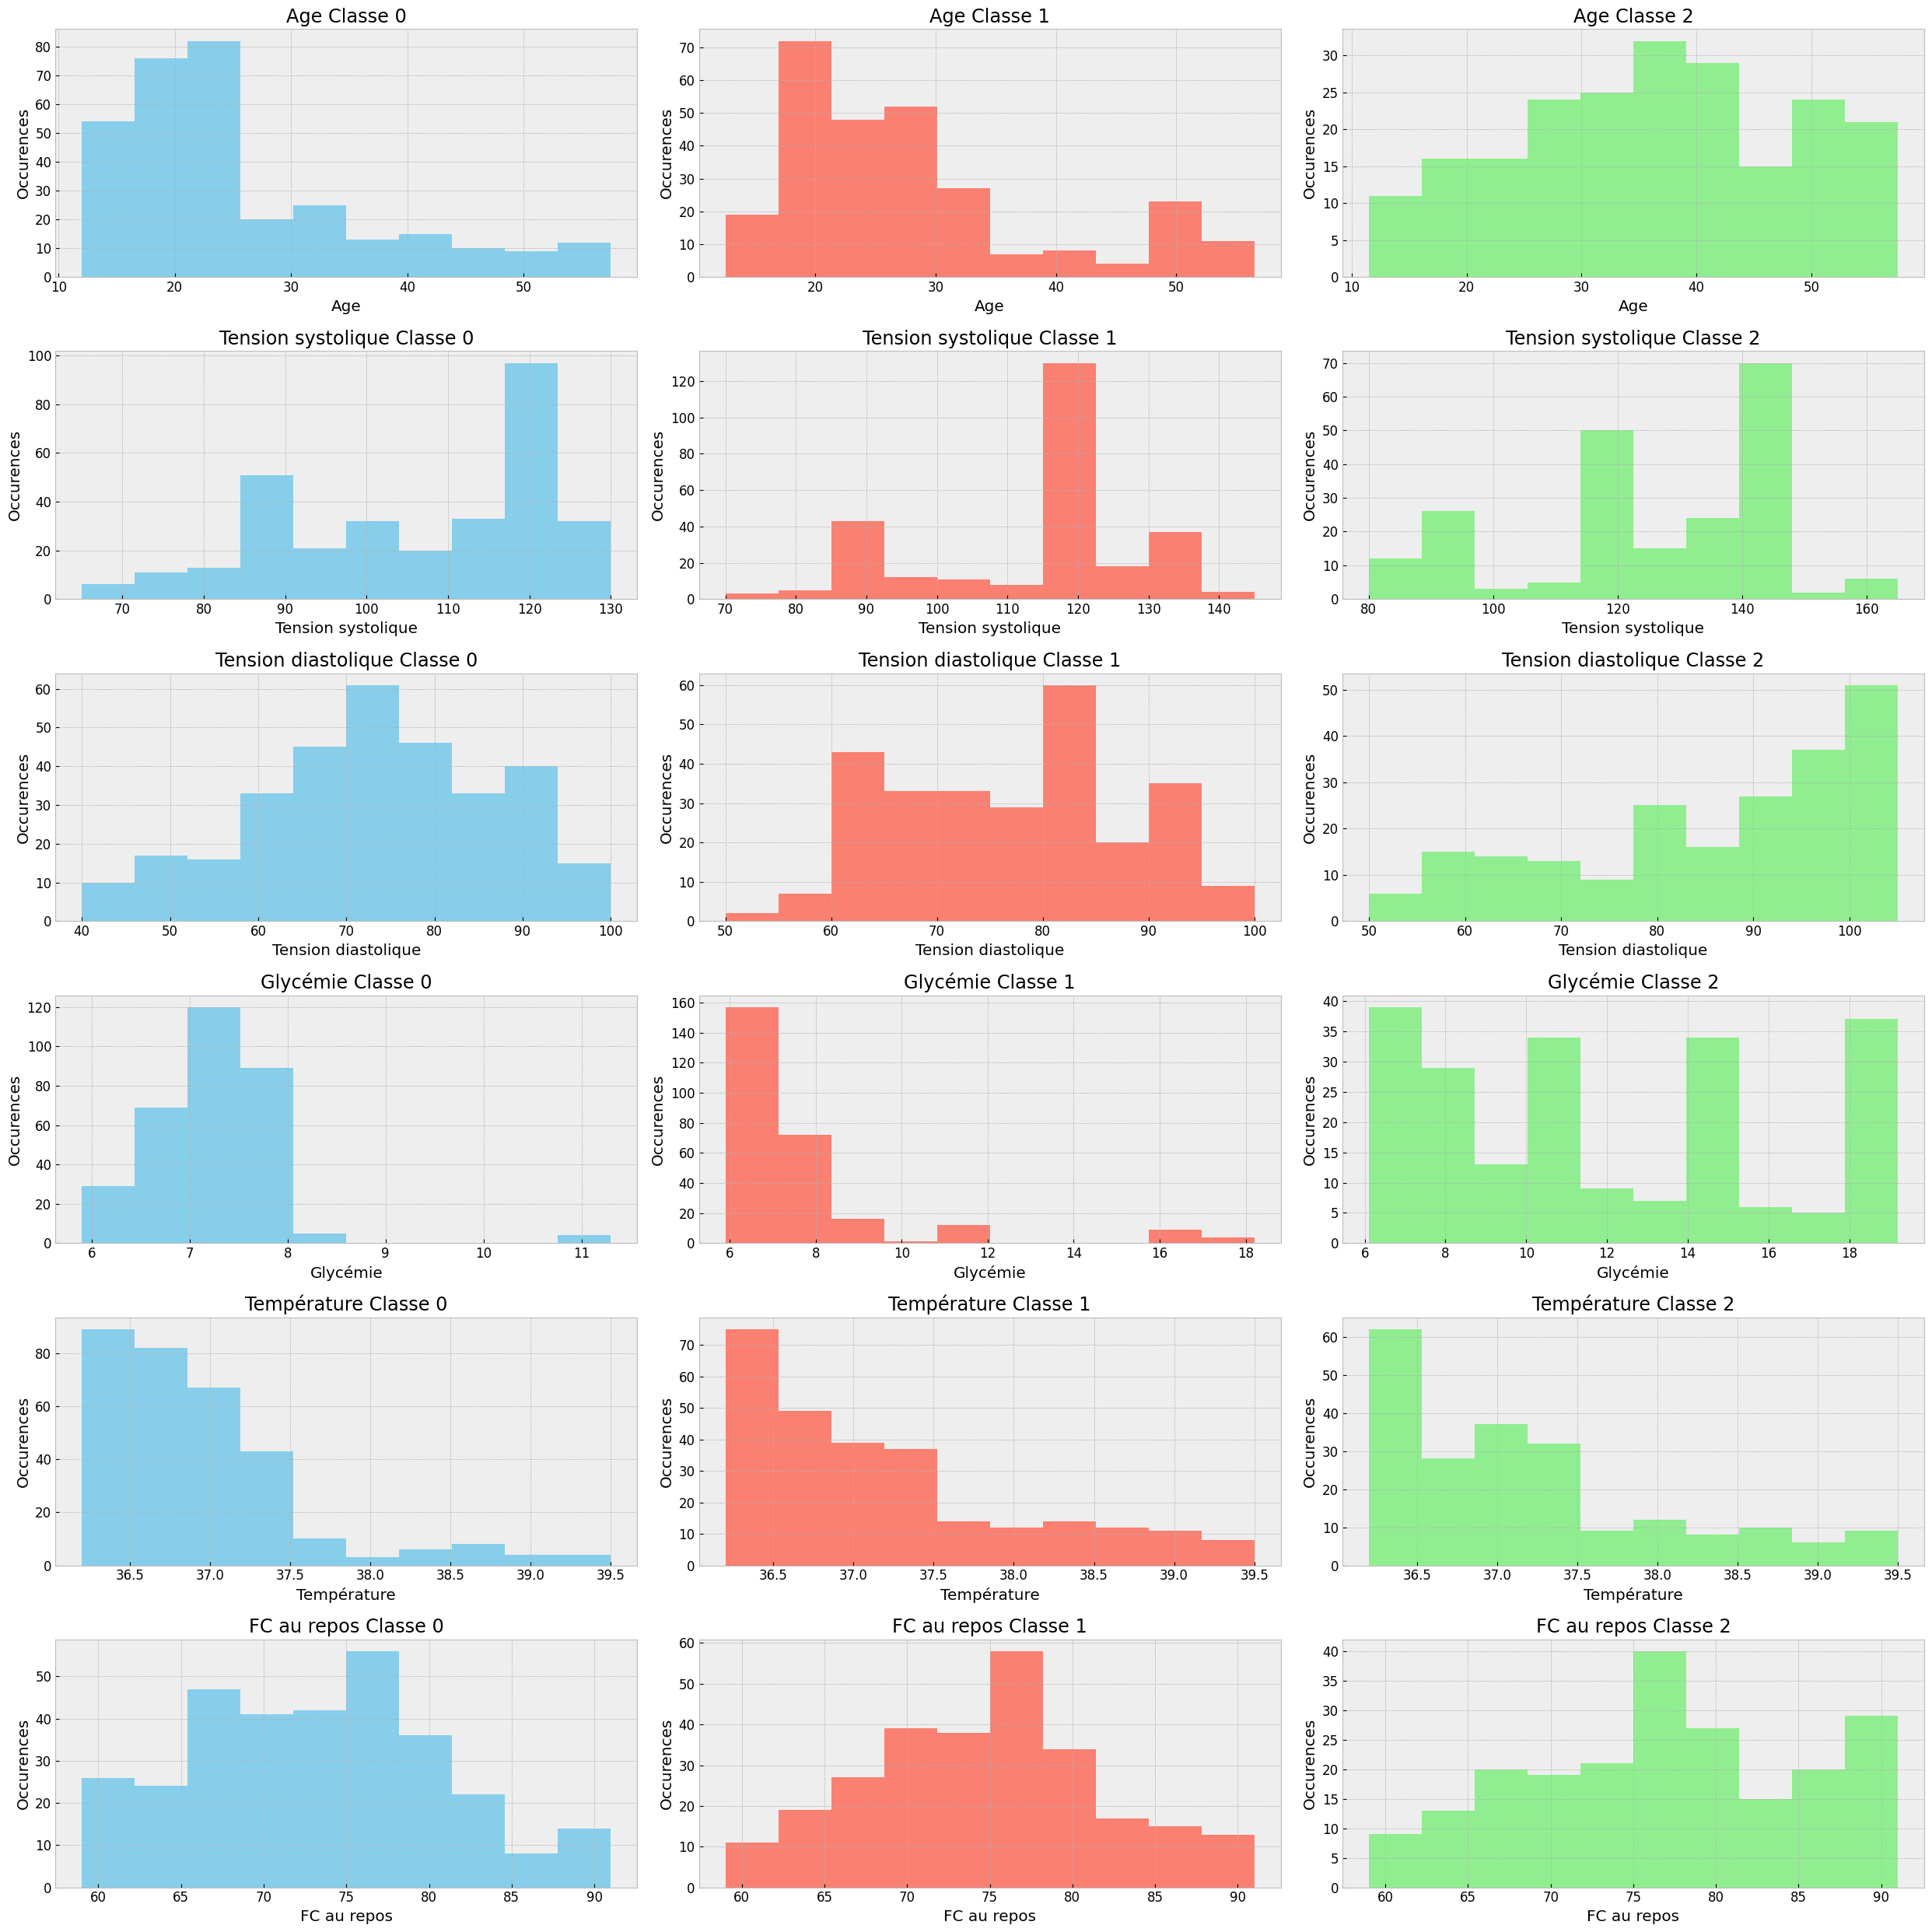

In [172]:
plt.style.use('bmh')
fig, axes = plt.subplots(6,3, figsize=(25, 25))
noms = ["Age","Tension systolique","Tension diastolique","Glycémie","Température","FC au repos"]

bins = 10
colors = ['skyblue', 'salmon', 'lightgreen']

for i in range(len(noms)):
    for j in range(3):
        mask = y_train == j
        data = X_train[mask][:,i]
        axes[i][j].hist(data, bins = bins, color = colors[j])
        axes[i][j].set_title(noms[i] + " " + f'Classe {j}')
        axes[i][j].set_xlabel(noms[i])
        axes[i][j].set_ylabel('Occurences')
    
fig.tight_layout()
plt.show()

### Question 3 (1 pt)
Les valeurs prises par ces variables sont-elles surprenantes ? Cohérentes avec le degré de risque ?

On observe que pour la plupart des variables, les valeurs extrèmes (âge, température, glycémie, ... élevés) sont plus fréquentes chez les femmes de classe 2 que chez les femmes de classe 0, ce qui est cohérent.

### Question 4 (1 pt)
Pensez-vous qu'il va être facile/difficile de prédire le risque de grossesse à risque en utilisant ces 6 variables ?

Il semble y avoir une forte corrélation entre ces 6 variables et le risque de grossesse, ainsi il serait plutôt facile de prédire le risque de grossesse en les utilisant.

## Réduction de dimension

Indépendamment de votre réponse à la question précédente, nous allons procéder à deux tentatives de réduction de dimension.

### Question 5 (1 pt)
Utilisez la décomposition en composantes principales de `X_train` pour visualiser les données en deux dimensions.

In [173]:
from sklearn import preprocessing
from sklearn import decomposition

std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = std_scale.transform(X_train)

pca = decomposition.PCA(n_components=6)
pca.fit(X_train_scaled)

,n_components,6
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,None


Text(0, 0.5, 'Proportion cumulative de variance expliquée')

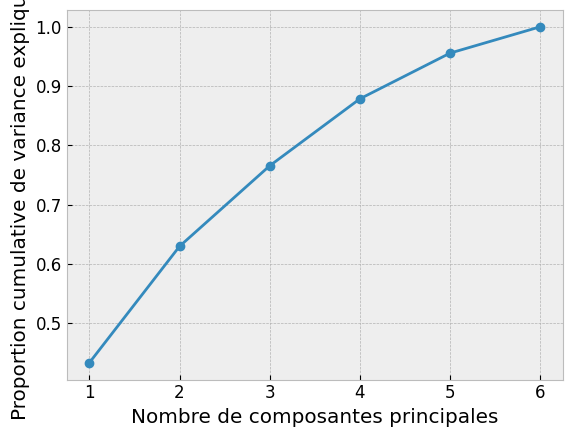

In [174]:
plt.plot(np.arange(1,7), np.cumsum(pca.explained_variance_ratio_), marker='o')

plt.xlabel("Nombre de composantes principales")
plt.ylabel("Proportion cumulative de variance expliquée")

#On peut déjà remarquer que les deux première CP expliquent plus de 60% de la variance

In [175]:
pca = decomposition.PCA(n_components=2)
pca.fit(X_train_scaled)
X_train_projected = pca.transform(X_train_scaled)
print(X_train_projected.shape)

(800, 2)


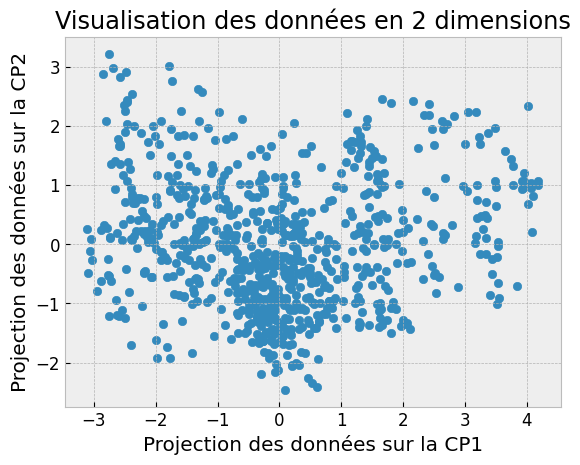

In [176]:
plt.scatter(X_train_projected[:,0], X_train_projected[:,1], marker='o')
plt.title("Visualisation des données en 2 dimensions")
plt.xlabel("Projection des données sur la CP1")
plt.ylabel("Projection des données sur la CP2")
plt.show()

### Question 6 (1 pt) 
Pensez-vous utile d'utiliser cette ACP pour réduire la dimension des données pour construire un prédicteur de risque de grossesse difficile ?

Cette ACP semble très pertinente : 
- elle permet de réduire le nombre de variable utiliser sans trop perdre en information (60% de la variance expliquée). En effet, on voit sur le graphique que les valeurs sont toujours bien réparties et que les deux variable ne semble ar corrélées.
- elle permet de "supprimer" des variable innutiles car certaines paraissent très corrélées.

### Question 7 (0,5 pt)
Affichez la matrice de corrélation entre les variables (étiquette exclue)

                          Age  Tension systolique  Tension diastolique  \
Age                  1.000000            0.482660             0.428986   
Tension systolique   0.482660            1.000000             0.728700   
Tension diastolique  0.428986            0.728700             1.000000   
Glycémie             0.523127            0.412167             0.409977   
Température         -0.218975           -0.239331            -0.224814   
FC au repos          0.034682           -0.064791            -0.085336   

                     Glycémie  Température  FC au repos  
Age                  0.523127    -0.218975     0.034682  
Tension systolique   0.412167    -0.239331    -0.064791  
Tension diastolique  0.409977    -0.224814    -0.085336  
Glycémie             1.000000    -0.095702     0.121770  
Température         -0.095702     1.000000     0.155140  
FC au repos          0.121770     0.155140     1.000000  


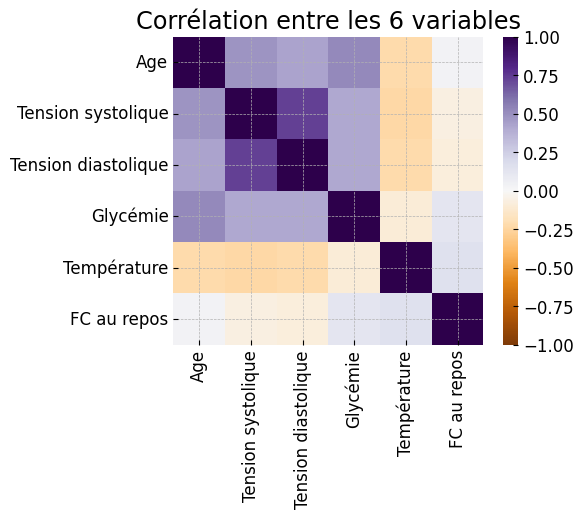

In [177]:
import seaborn as sns

corr_matrix = df_train.drop(columns = ["Risque"]).corr()
plt.figure(figsize=(5, 4))
sns.heatmap(corr_matrix, 
            vmin=-1, # borne inf des valeurs à afficher
            vmax=1, # borne sup des valeurs à afficher
            center= 0, # valeur médiane des valeurs à afficher,
            cmap='PuOr', # colormap divergente de violet (PUrple) vers orange (ORange)
           )
plt.title("Corrélation entre les 6 variables")
print(corr_matrix)

### Question 8 (0,5 pt)

Comment utiliser cette matrice de corrélation pour réduire la dimension des données ?

On remarque que les tensions systolique et diastolique sont très fortement corrélées (>0.72). On pourra donc ne garder qu'une de ces deux variables.

# 2. Classification «à risque» vs «sans risque»

Nous allons maintenant transformer les étiquettes en étiquettes binaire, en regroupant les risques obstétriques moyens et élevés. Les étiquettes `1` et `2` seront regroupées en une seule étiquette `1`.

In [178]:
# Copier le dataframe initial dans un nouveau dataframe 
df_train_risk_vs_norisk = df_train.copy()

# Regrouper les étiquettes 1 et 2
df_train_risk_vs_norisk['Risque'] = np.where(df_train['Risque']==2, 1, df_train['Risque'])

# Extraction de l'array d'étiquettes
y_train_risk_vs_norisk = np.array(df_train_risk_vs_norisk['Risque'], dtype='int')

## Choix du critère d'évaluation
Pour cette section, on pourra se référer à la section 8.7.1 du poly.

### Question 9 (0,25 pt)
Quelle serait l'_accuracy_ (proportion d'observations correctement étiquetées) d'un modèle qui prédit que toutes les observations appartiennent à la classe majoritaire (c'est-à-dire la classe ayant le plus grand nombre d'observations dans les données) ? 

Dans le cas où la classe majoritaire serait 0, l'accuracy du modèle serait la proportion de femmes sans risques dans la population.
Dans le cas où la classe majoritaire serait 1, l'accuracy du modèle serait la proportion de femmes à risques dans la population.

### Question 10 (0,25 pt) 
La __précision équilibrée__ (_balanced accuracy_) d'un classifieur binaire est donnée par :

$$BA = \frac12 \left( \frac{\text{TP}}{\text{TP}+\text{FN}} +  \frac{\text{TN}}{\text{TN}+\text{FP}} \right)$$

Expliquez pourquoi ce critère d'évaluation est plus pertinent que l'accuracy pour sélectionner un classifieur optimal.

La balanced accuracy permet de séparer les observations correctement étiquetées en observations positives correctement étiquetées et en observations négatives correctement étiquetées. Ainsi, dans le cas d'une maladie rare par exemple (99.9% de la population est négative), si le test renvoie négatif dans 100% des cas, l'accuracy du test sera proche de 100% tandis que sa balanced accuracy sera plutôt proche de 50%. La balanced accuracy est donc plus pertinente que l'accuracy.


Dans la suite du projet, nous utiliserons ce critère, implémenté dans la méthode [metrics.balanced_accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html) de scikit-learn.

## Plus proche voisin
L'algorithme du plus proche voisin associe à une observation $\vec{x}$ l’étiquette du point du jeu d’entraînement dont elle est la plus proche (par défaut, en distance euclidienne).

### Question 11 (0,5 pt)
En quoi consiste la phase d'entraînement d'un tel classifieur ?

Il ne s'y passe presque rien ; l'algorithme va seulement y memoriser le jeu de données d'entrainement, c'est à dire les couples (variables,étiquettes).

### Question 12 (0,5 pt)
Quelle précision équilibrée attendez-vous _sur le jeu d'entraînement_ d'un algorithme du plus proche voisin ? Pourquoi ?

Il est naturel de s'attendre à une balanced accuracy de 1 puisque le plus proche voisin de chaque point sera le point lui-même.

### Question 13 (0,5 pt)
Vérifiez votre réponse sur les données, en utilisant la classe [neighbors.KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html).

In [179]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(X_train_scaled, y_train_risk_vs_norisk)

,n_neighbors,1
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [180]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(np.array(neigh.predict(X_train_scaled)), y_train_risk_vs_norisk)

1.0

### Quesion 14 (0,5 pt)
Pour cet algorithme, vaut-il mieux utiliser les données d'origine ou les données centrées-réduites ? Justifiez votre réponse.

Il faut utiliser les données centrées réduites pour donner la même importance à toutes les variables.

## K plus proches voisins
L'algorithme des $K$ plus proche voisins associe à une observation $\vec{x}$ l’étiquette qui est majoritaires parmi celle des $K$ points du jeu d’entraînement dont elle est la plus proche (par défaut, en distance euclidienne).

### Question 15 (1,5 pt)
Utilisez une recherche sur grille avec une validation croisée en 10 _folds_ (voir amphi 7 et PC5) pour déterminer une valeur optimale de $K$. 

* Justifiez votre choix de grille de valeurs.
* Illustrez par un graphique approprié votre exploration de cette grille.
* Commentez ce graphique.
* Reportez la valeur optimale de l'hyperparamètre et la précision équilibrée correspondante.

In [181]:
from sklearn import model_selection

kf = model_selection.KFold(n_splits=10, shuffle=True, random_state=42)

In [182]:
k_grille = np.arange(1,40,2)

neighk = KNeighborsClassifier()

grid_k = model_selection.GridSearchCV(neighk, {'n_neighbors' : k_grille}, cv = kf, scoring = 'balanced_accuracy')

grid_k.fit(X_train_scaled, y_train_risk_vs_norisk)


,estimator,KNeighborsClassifier()
,param_grid,"{'n_neighbors': array([ 1, 3... 35, 37, 39])}"
,scoring,'balanced_accuracy'
,n_jobs,None
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_neighbors,np.int64(27)


In [183]:
grid_k.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_n_neighbors', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

C:\Users\simon\AppData\Local\Temp\ipykernel_4068\2055340013.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best')


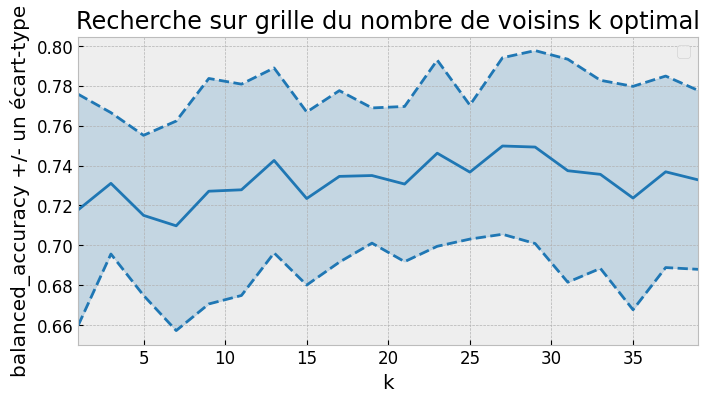

In [184]:
plt.figure(figsize=(8, 4))

balanced_accuracies = grid_k.cv_results_['mean_test_score']
std_error = grid_k.cv_results_['std_test_score']

plt.plot(grid_k.cv_results_['param_n_neighbors'], balanced_accuracies, 
         color='tab:blue')
plt.plot(grid_k.cv_results_['param_n_neighbors'], balanced_accuracies + std_error, 
             color='tab:blue', linestyle='dashed')
plt.plot(grid_k.cv_results_['param_n_neighbors'], balanced_accuracies - std_error, 
             color='tab:blue', linestyle='dashed')

plt.fill_between(grid_k.cv_results_['param_n_neighbors'], (balanced_accuracies + std_error), (balanced_accuracies - std_error), 
                 color='tab:blue',
                 alpha=0.2,
                )

plt.xlabel("k")
plt.ylabel("balanced_accuracy +/- un écart-type")
plt.xlim([k_grille[0], k_grille[-1]])
plt.title("Recherche sur grille du nombre de voisins k optimal")
plt.legend(loc='best')

J'ai d'abord choisi k_grille = np.arange(1,100,2) (on saute de 2 en 2 pour ne tester que les nombres impais qui sont préféres dans les algorithmes knn) et me suis rendu compte que mon maximum était atteint aux alentours de 30. J'ai donc réduit à k_grille = np.arange(1,40,2). On observe donc que la balanced accuracy augmente d'abord avec k puis diminue ensuite. Le maximum est atteint pour k = 29 et la balanced accuracy correspondante vaut 0.75.

## Régression logistique
Le pendant pour la classification binaire de la régression linéaire (amphi 7 et PC 5) est la __régression logistique__ (PC 6). Dans scikit-learn, elle est implémentée par la classe [linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

### Question 16 (1 pt) 
Utilisez une recherche sur grille avec une validation croisée en 10 _folds_ pour déterminer une valeur optimale du coefficient de régularisation d'une régression logistique. 

* Justifiez votre choix de type de régularisation et de grille de valeurs. 
* Illustrez par un graphique approprié votre exploration de cette grille. 
* Commentez ce graphique.
* Reportez la valeur optimale de l'hyperparamètre et la précision équilibrée correspondante.

In [185]:
from sklearn import linear_model

kf = model_selection.KFold(n_splits=10, shuffle=True, random_state=42)

In [186]:
C = np.logspace(-6, 3, 40)

log_regression = linear_model.LogisticRegression(penalty = 'l2', random_state=42, 
                           max_iter=10000
                          )

grid_log = model_selection.GridSearchCV(log_regression, {'C': C}, # d'après la documentation, C is the "Inverse of regularization strength"
                                    cv=kf, 
                                    scoring = 'balanced_accuracy'
                                   )

grid_log.fit(X_train_scaled, y_train_risk_vs_norisk)

,estimator,LogisticRegre...ndom_state=42)
,param_grid,{'C': array([1.0000...00000000e+03])}
,scoring,'balanced_accuracy'
,n_jobs,None
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


In [187]:
grid_log.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_C', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

C:\Users\simon\AppData\Local\Temp\ipykernel_4068\2041441824.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best')


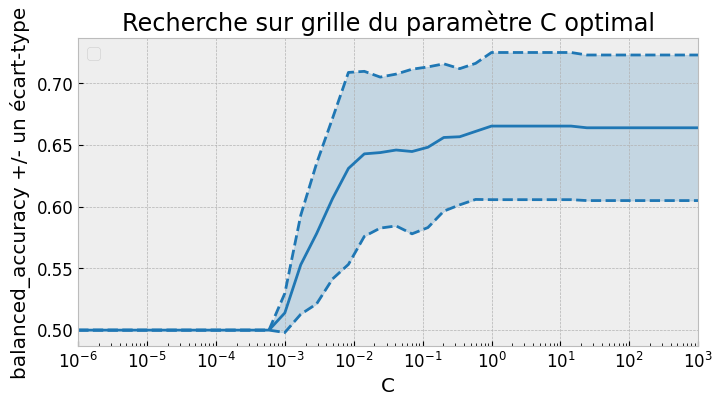

In [189]:
plt.figure(figsize=(8, 4))

balanced_accuracies = grid_log.cv_results_['mean_test_score']
std_error = grid_log.cv_results_['std_test_score']

plt.semilogx(grid_log.cv_results_['param_C'], balanced_accuracies, 
         color='tab:blue')
plt.semilogx(grid_log.cv_results_['param_C'], balanced_accuracies + std_error, 
             color='tab:blue', linestyle='dashed')
plt.semilogx(grid_log.cv_results_['param_C'], balanced_accuracies - std_error, 
             color='tab:blue', linestyle='dashed')

plt.fill_between(grid_log.cv_results_['param_C'], (balanced_accuracies + std_error), (balanced_accuracies - std_error), 
                 color='tab:blue',
                 alpha=0.2,
                )

plt.xlabel("C")
plt.ylabel("balanced_accuracy +/- un écart-type")
plt.xlim([C[0], C[-1]])
plt.title("Recherche sur grille du paramètre C optimal")
plt.legend(loc='best')

C est l'inverse de alpha selon la documentation (alpha est noté lambda dans notre cours). Plus C est grand, plus la régularisation est faible. On remarque que lorsque la régularisation est trop forte, notre balanced accuracy vaut 0.5, ce qui est normal puisque on cherche alors uniquement à minimiser la norme l2 de notre coefficient : on n'entraine pas le modèle. En revanche, le graphique obtenu montre que si l'on cherche à maximiser la balanced accuracy, il faut apparemment utiliser un C grand, c'est à dire ne quasi pas régulariser. Le maximum est atteint pour C = 1 et la balanced accuracy vaut alors 0.73.

## Algorithme non-linéaire

### Question 17 (2pt)
Choisissez maintenant un algorithme permettant d'apprendre un modèle non-linéaire parmi ceux du chapitre 9 :
* arbre de décision : [tree.DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
* forêt aléatoire : [ensemble.RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
* machine à vecteur de support à noyau : [svm.SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
* perceptron multi-couche : [neural_network.MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)

Utilisez encore une fois une recherche sur grille avec une validation croisée en 10 _folds_ pour sélectionner le(s) hyperparamètre(s) le(s) plus pertinent(s).

* Justifiez votre choix d'hyperparamètre(s) à optimiser.
* Justifiez votre choix de grille de valeurs pour ces ou cet hyperparèmtre(s).
* Illustrez par un graphique approprié votre exploration de cette grille.
* Commentez ce graphique.
* Reportez la ou les valeur(s) optimale(s) d'hyperparamètre(s) et la précision équilibrée correspondante.

In [190]:
from sklearn import tree

kf = model_selection.KFold(n_splits=10, shuffle=True, random_state=42)

In [191]:
depth_grid = [i for i in range (1,30)]
   
tree_decision = tree.DecisionTreeClassifier(random_state=42, 
                          )

grid_tree = model_selection.GridSearchCV(tree_decision, {"max_depth" : depth_grid}, 
                                    cv=kf, 
                                    scoring = 'balanced_accuracy'
                                   )

grid_tree.fit(X_train_scaled, y_train_risk_vs_norisk)

,estimator,DecisionTreeC...ndom_state=42)
,param_grid,"{'max_depth': [1, 2, ...]}"
,scoring,'balanced_accuracy'
,n_jobs,None
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


In [ ]:
grid_tree.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_max_depth', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

C:\Users\simon\AppData\Local\Temp\ipykernel_4068\3607410690.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best')


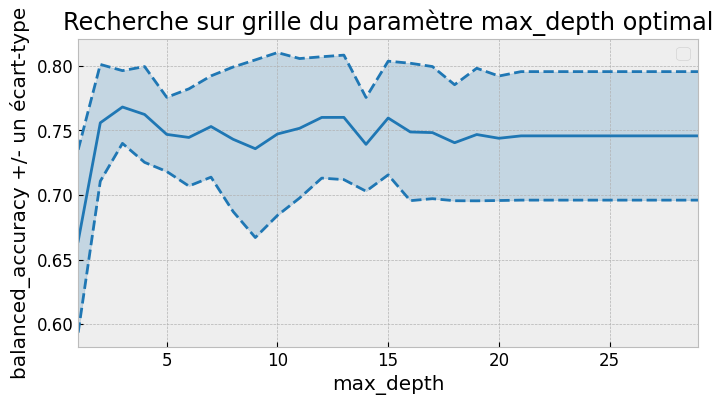

In [192]:
plt.figure(figsize=(8, 4))

balanced_accuracies = grid_tree.cv_results_['mean_test_score']
std_error = grid_tree.cv_results_['std_test_score']

plt.plot(grid_tree.cv_results_['param_max_depth'], balanced_accuracies, 
         color='tab:blue')
plt.plot(grid_tree.cv_results_['param_max_depth'], balanced_accuracies + std_error, 
             color='tab:blue', linestyle='dashed')
plt.plot(grid_tree.cv_results_['param_max_depth'], balanced_accuracies - std_error, 
             color='tab:blue', linestyle='dashed')

plt.fill_between(grid_tree.cv_results_['param_max_depth'], (balanced_accuracies + std_error), (balanced_accuracies - std_error), 
                 color='tab:blue',
                 alpha=0.2,
                )

plt.xlabel("max_depth")
plt.ylabel("balanced_accuracy +/- un écart-type")
plt.xlim([depth_grid[0], depth_grid[-1]])
plt.title("Recherche sur grille du paramètre max_depth optimal")
plt.legend(loc='best')

D'après la documentation que j'ai pu trouvé sur internet, le paramètre max_depth est celui qui contrôle la complexité du môdèle arbre de décision. C'est donc l'hyperparamètre que j'ai choisi d'optimiser. J'ai commencé par utiliser depth_grid = [i for i in range (1,100)] mais la balanced_accuracy devenait constante après 30. J'ai donc réduit la grille à depth_grid = [i for i in range (1,30)]. On observe que la balanced_accuracy augmente d'abord avec le paramètre max_depth (underfitting) puis rediminue avant de stagner (overfitting). Le maximum est atteint en max_depth = 10 et la balanced accuracy vaut alors 0.81.

## Classification après réduction de dimension

Nous allons maintenant évaluer l'impact d'une réduction de dimension sur la qualité de l'apprentissage.

### Question 18 (0,25 pt)
Quel algorithme (k plus proches voisins ; régression logistique ; algorithme non-linéaire de la question 16) vous a permis d'obtenir la meilleure performance ? 

C'est l'arbre de décision avec max_depth = 10 qui nous permis d'obtenir la meilleur performance : balanced_accuracy = 0.81.

### Quesion 19 (0,25 pt)
Utilisez le travail des questions 4 à 7 pour créer une nouvelle matrice représentant les données dans moins de dimensions qu'originellement. 

Option I : on élimine un des deux tensions.

In [193]:
X_train_drop = np.array(df_train.drop(columns = ['Tension diastolique', 'Risque']))
std_scale = preprocessing.StandardScaler().fit(X_train_drop)
X_train_drop_scaled = std_scale.transform(X_train_drop)

Option II : on prend X_train_projected (on a déjà cette matrice obtenue par ACP)

### Question 20 (0,25 pt)
Utilisez encore une fois une recherche sur grille pour optimiser les performances de cet algorithme, mais entrainé sur cette nouvelle matrice. 

Option I :

In [194]:
kf = model_selection.KFold(n_splits=10, shuffle=True, random_state=42)

In [195]:
depth_grid2 = [i for i in range (1,30)]
   
tree_decision = tree.DecisionTreeClassifier(random_state=42, 
                          )

grid_tree2 = model_selection.GridSearchCV(tree_decision, {"max_depth" : depth_grid2}, 
                                    cv=kf, 
                                    scoring = 'balanced_accuracy'
                                   )

grid_tree2.fit(X_train_drop_scaled, y_train_risk_vs_norisk)

,estimator,DecisionTreeC...ndom_state=42)
,param_grid,"{'max_depth': [1, 2, ...]}"
,scoring,'balanced_accuracy'
,n_jobs,None
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


In [196]:
grid_tree2.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_max_depth', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

C:\Users\simon\AppData\Local\Temp\ipykernel_4068\395848690.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best')


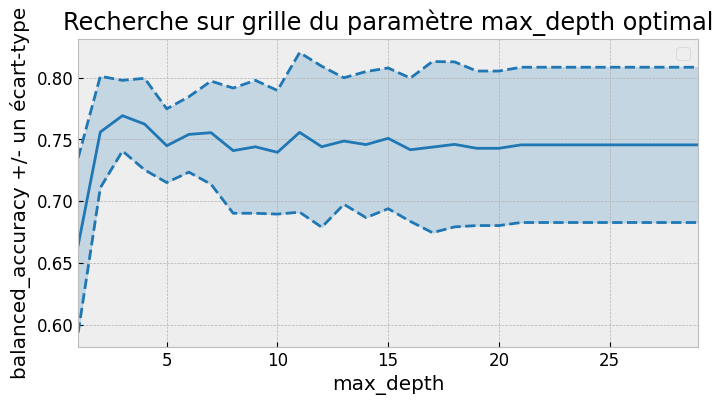

In [197]:
plt.figure(figsize=(8, 4))

balanced_accuracies = grid_tree2.cv_results_['mean_test_score']
std_error = grid_tree2.cv_results_['std_test_score']

plt.plot(grid_tree2.cv_results_['param_max_depth'], balanced_accuracies, 
         color='tab:blue')
plt.plot(grid_tree2.cv_results_['param_max_depth'], balanced_accuracies + std_error, 
             color='tab:blue', linestyle='dashed')
plt.plot(grid_tree2.cv_results_['param_max_depth'], balanced_accuracies - std_error, 
             color='tab:blue', linestyle='dashed')

plt.fill_between(grid_tree2.cv_results_['param_max_depth'], (balanced_accuracies + std_error), (balanced_accuracies - std_error), 
                 color='tab:blue',
                 alpha=0.2,
                )

plt.xlabel("max_depth")
plt.ylabel("balanced_accuracy +/- un écart-type")
plt.xlim([depth_grid2[0], depth_grid2[-1]])
plt.title("Recherche sur grille du paramètre max_depth optimal")
plt.legend(loc='best')

Option II : 

In [198]:
depth_grid3 = [i for i in range (1,30)]
   
tree_decision = tree.DecisionTreeClassifier(random_state=42, 
                          )

grid_tree3 = model_selection.GridSearchCV(tree_decision, {"max_depth" : depth_grid3}, 
                                    cv=kf, 
                                    scoring = 'balanced_accuracy'
                                   )

grid_tree3.fit(X_train_projected, y_train_risk_vs_norisk)

,estimator,DecisionTreeC...ndom_state=42)
,param_grid,"{'max_depth': [1, 2, ...]}"
,scoring,'balanced_accuracy'
,n_jobs,None
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


C:\Users\simon\AppData\Local\Temp\ipykernel_4068\109043676.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best')


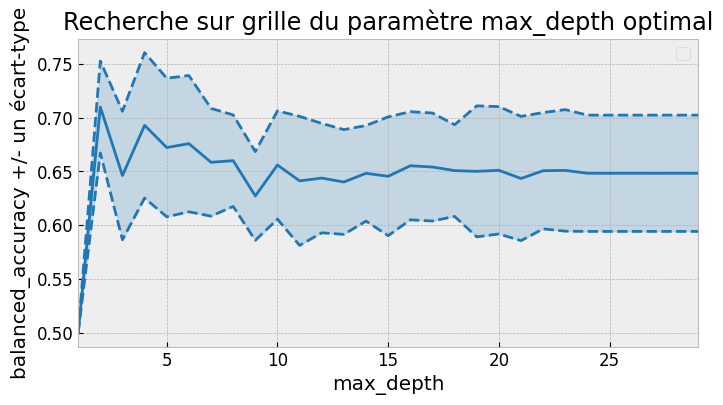

In [199]:
plt.figure(figsize=(8, 4))

balanced_accuracies = grid_tree3.cv_results_['mean_test_score']
std_error = grid_tree3.cv_results_['std_test_score']

plt.plot(grid_tree3.cv_results_['param_max_depth'], balanced_accuracies, 
         color='tab:blue')
plt.plot(grid_tree3.cv_results_['param_max_depth'], balanced_accuracies + std_error, 
             color='tab:blue', linestyle='dashed')
plt.plot(grid_tree3.cv_results_['param_max_depth'], balanced_accuracies - std_error, 
             color='tab:blue', linestyle='dashed')

plt.fill_between(grid_tree3.cv_results_['param_max_depth'], (balanced_accuracies + std_error), (balanced_accuracies - std_error), 
                 color='tab:blue',
                 alpha=0.2,
                )

plt.xlabel("max_depth")
plt.ylabel("balanced_accuracy +/- un écart-type")
plt.xlim([depth_grid3[0], depth_grid3[-1]])
plt.title("Recherche sur grille du paramètre max_depth optimal")
plt.legend(loc='best')

### Question 21 (0,25 pt)
La réduction de dimension a-t-elle été utile ? Commentez.

Dans le cas de l'option I, la réduction de dimension a été utile : le maximum de balanced accuracy a augmenté et vaut plus de 0.82 pour max_depth = 11.
En revance, dans le cas de l'ACP à deux composantes principales, la réduction de dimension a entrainé une baisse de la balanced_accuracy.

## Classifieur final

### Question 22 (0,25 pt)
Au vu des performances observées jusqu'à présent, quel est l'algorithme d'apprentissage, son ou ses valeurs d'hyperparamètres, la transformation des données qui permettent d'obtenir la meilleure performance ? 

Utilisez cet algorithme pour entraîner un modèle de classification final `final_binary_classifier` sur l'ensemble du jeu d'entraînement.

Le meilleur algorithme est donc l'arbre de decision d'hyperparamètre max_depth = 11, entrainé sur la dataframe à 5 variables.

In [252]:
final_binary_classifier = tree.DecisionTreeClassifier(random_state=42, max_depth = 11)
final_binary_classifier.fit(X_train_drop_scaled, y_train_risk_vs_norisk)

,criterion,'gini'
,splitter,'best'
,max_depth,11
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


### Question 23 (0,25 pt)

Chargez les données du jeu de test `data/donnees_reservees.csv`. Combinez les étiquettes 1 et 2 en une seule classe. 

In [253]:
df_test= pd.read_csv("data/donnees_reservees.csv")
df_test['Risque'] = np.where(df_test['Risque']==2, 1, df_test['Risque'])
y_test = np.array(df_test["Risque"])


In [254]:

df_test = df_test.drop(columns = ["Tension diastolique", "Risque"])
df_test.head()

,Age,Tension systolique,Glycémie,Température,FC au repos
0,20.5,120.0,6.6,36.7,71.0
1,50.5,130.0,15.9,36.3,72.0
2,23.0,120.0,7.5,37.0,64.0
3,17.5,120.0,7.2,36.2,65.0
4,23.5,125.0,8.1,36.7,64.0


### Question 24 (0,25 pt)

Utilisez `final_binary_classifier` pour prédire les étiquettes des observations de ce jeu de données. (N'oubliez pas d'appliquer d'éventuelles transformation des données.) 

In [268]:
X_test_scaled = std_scale.transform(np.array(df_test))
y_predict = final_binary_classifier.predict(X_test_scaled)

### Question 25 (0,5 pt)
Comparez la précision équilibrée sur le jeu de test à celle obtenue en validation croisée lors de la sélection de modèle. Commentez.

In [ ]:
balanced_accuracy_score(y_predict, y_test)

0.7722222222222221

On obtient un précision équilibrée plus faible qu'en validation croisée.
Le modèle a du mal à généraliser.

### Question 26 (0,25 pt)
Utilisez [metrics.ConfusionMatrixDisplay](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html) pour afficher la matrice de confusion de ces prédictions.

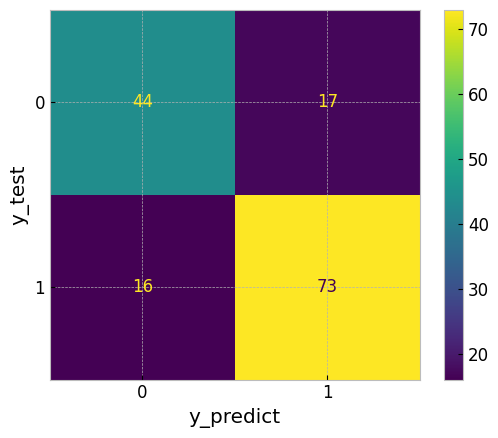

In [267]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

confusion_matrice = confusion_matrix(y_test, y_predict)

cm_display = ConfusionMatrixDisplay(confusion_matrice)

cm_display.plot()
plt.xlabel("y_predict")
plt.ylabel("y_test")
plt.show()

### Question 27 (0,5 pt)
Commentez cette matrice de précision.

Considéreriez vous possible d'utilise ce classifieur pour décider, sur la base de ces quelques mesures faciles à obtenir en autonomie, quelles femmes référer pour un suivi médical attentif de leur grossesse ?

On observe que le modèle a plus tendance à se tromper en attribuant une grossesse à risque à une femme dont la grossesse n'est pas à risque, ce qui est moins grave que d'attribuer une grossesse sans risque à une femme dont la grossesse est à risque. Cette matrice de précision est dont plutôt positive, car seule 17 predictions sur 15O sont potentiellement dangeureuses, c'est à dire un peu plus de 11%.

Ce score est mauvais si l'on considère que l'on a d'autres options. En revanche, dans des territoires où la seule option serait cet algorithme, ces resultats sont plutôts prometteurs.

# 3. Classification multi-classe

### Question 28 (0,5 pt)
Parmi les algorithmes d'apprentissage supervisé que vous avez utilisé dans la section 2, le(s)quel(s) se prête(nt) directement à entraîner un classifieur multiclasse ?

Seul la regression logistique ne s'y prète pas; knn et l'arbre de décision s'y prêtent tout à fait !

### Question 29 (1,5 pt)
Choisissez un des algorithmes mentionnés à la question précédente et entraînez-le sur le problème de classification multi-classe consistant à prédire le niveau (0, 1 ou 2) de risque obstétrique. Optimisez le ou les hyperparamètre(s) le(s) plus pertinent(s).

In [317]:
depth_grid4 = [i for i in range (1,30)]
   
tree_decision = tree.DecisionTreeClassifier(random_state=42, 
                          )

grid_tree4 = model_selection.GridSearchCV(tree_decision, {"max_depth" : depth_grid4}, 
                                    cv=kf, 
                                    scoring = 'balanced_accuracy'
                                   )

grid_tree4.fit(X_train_drop_scaled, y_train)

,estimator,DecisionTreeC...ndom_state=42)
,param_grid,"{'max_depth': [1, 2, ...]}"
,scoring,'balanced_accuracy'
,n_jobs,None
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


C:\Users\simon\AppData\Local\Temp\ipykernel_4068\319720004.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best')


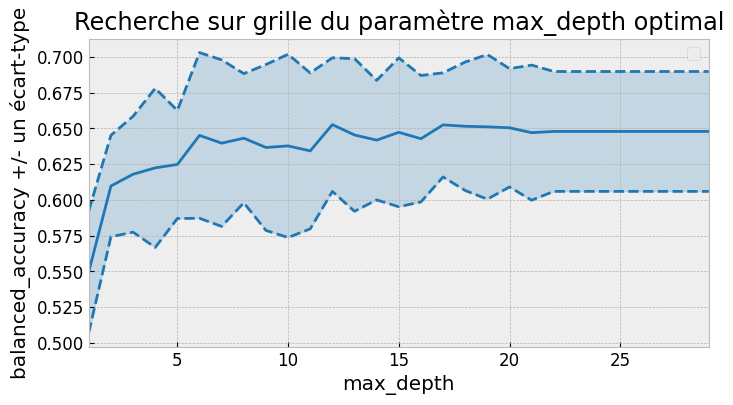

In [318]:
plt.figure(figsize=(8, 4))

balanced_accuracies = grid_tree4.cv_results_['mean_test_score']
std_error = grid_tree4.cv_results_['std_test_score']

plt.plot(grid_tree4.cv_results_['param_max_depth'], balanced_accuracies, 
         color='tab:blue')
plt.plot(grid_tree4.cv_results_['param_max_depth'], balanced_accuracies + std_error, 
             color='tab:blue', linestyle='dashed')
plt.plot(grid_tree4.cv_results_['param_max_depth'], balanced_accuracies - std_error, 
             color='tab:blue', linestyle='dashed')

plt.fill_between(grid_tree4.cv_results_['param_max_depth'], (balanced_accuracies + std_error), (balanced_accuracies - std_error), 
                 color='tab:blue',
                 alpha=0.2,
                )

plt.xlabel("max_depth")
plt.ylabel("balanced_accuracy +/- un écart-type")
plt.xlim([depth_grid4[0], depth_grid4[-1]])
plt.title("Recherche sur grille du paramètre max_depth optimal")
plt.legend(loc='best')

Le max_depth optimal est 20 et la balanced accuracy correspondante vaut 0.65

### Question 30 (1pt)
Utilisez cet algorithme pour entraîner un modèle multi-classe final sur l'ensemble des données d'entraînement. Évaluez ce modèle sur les données de test. Commentez.

In [319]:
final_classifier = tree.DecisionTreeClassifier(random_state=42, max_depth = 20)
final_classifier.fit(X_train_drop_scaled, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,20
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [320]:
df_test_bis= pd.read_csv("data/donnees_reservees.csv")
y_test_bis = np.array(df_test_bis["Risque"])
y_predict_bis = final_classifier.predict(X_test_scaled)

In [321]:
balanced_accuracy_score(y_predict_bis, y_test_bis)

0.7564856451054998

Le résulat est meilleur sur les données de test que les données d'entrainement ce qui est étonnant mais je n'arrive pas à déceler d'erreur.